In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as f

In [30]:
torch.set_default_dtype(torch.float64)

In [31]:
df = pd.read_csv("../dataset/ETTh1.csv", encoding="utf-8")
df.head(5)

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


In [32]:
df.index = pd.to_datetime(df.pop("date"))
df.head(5)

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
date,,,,,,,
2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>], dtype=object)

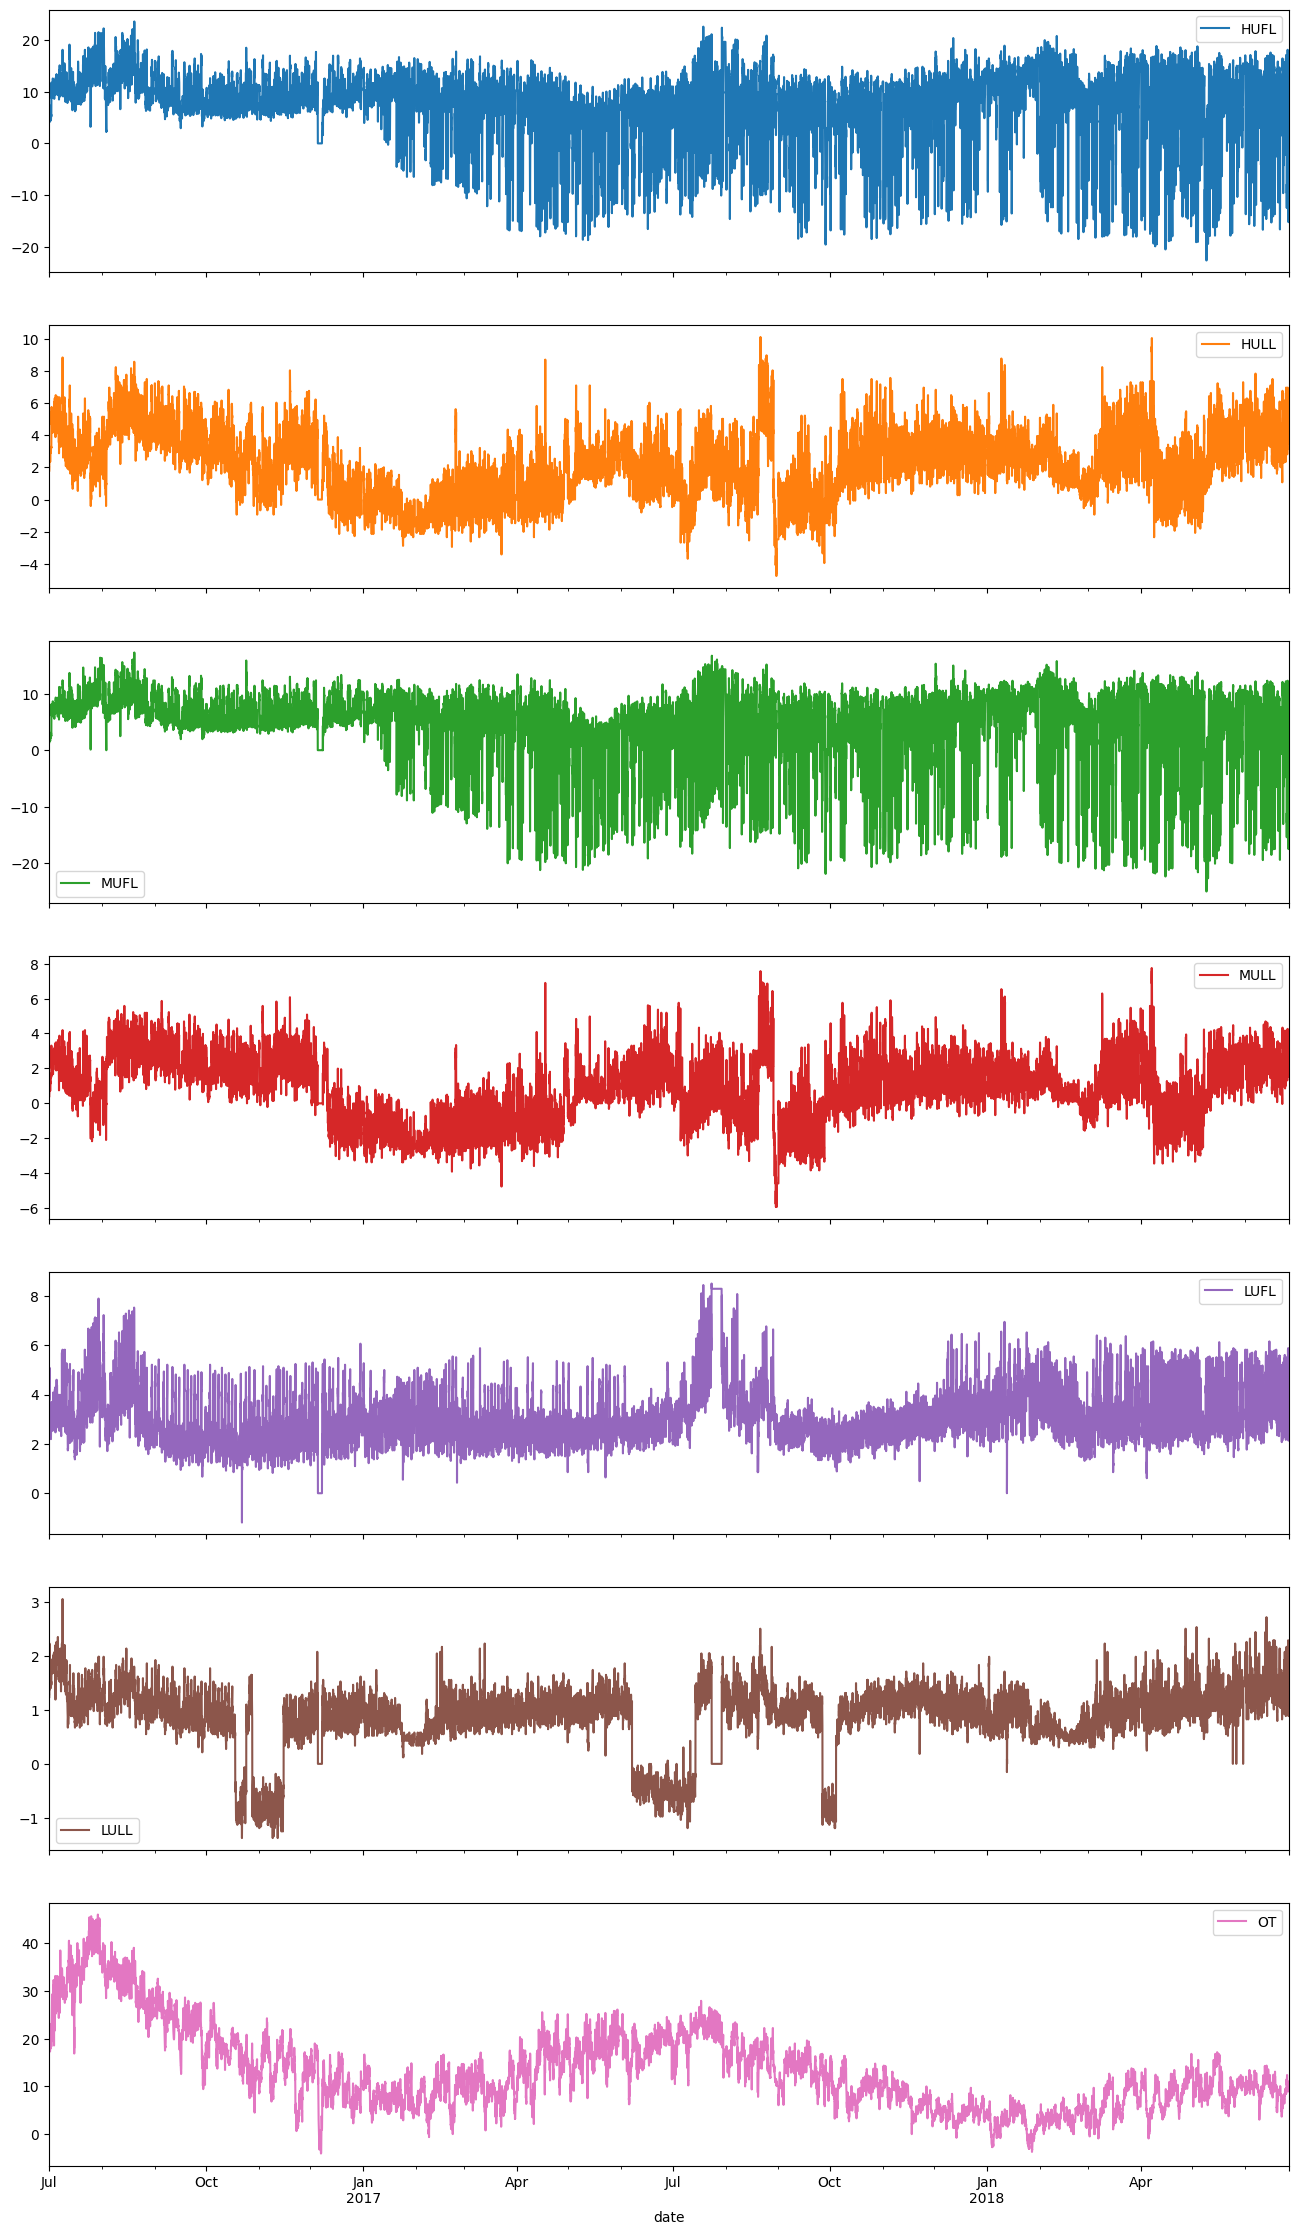

In [33]:
# df.plot(subplots=True, figsize=(16, len(df.columns) * 4))

In [34]:
x = torch.tensor(df["OT"])
x

tensor([30.5310, 27.7870, 27.7870,  ..., 10.2710,  9.7780,  9.5670])

In [35]:
t = torch.tensor(df.index.astype("int64") / 10**9 / 3600)
t

tensor([407592., 407593., 407594.,  ..., 425009., 425010., 425011.])

In [36]:
K = len(x)
tK = t[-1] - t[0]
tK

tensor(17419.)

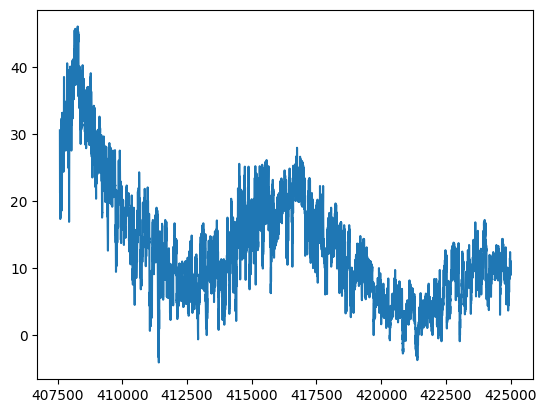

In [37]:
plt.plot(t, x)

In [38]:
T = t[1] - t[0]
T

tensor(1.)

In [39]:
L = 16
tL = L * T
tL

tensor(16.)

In [40]:
F = 16
tF = F * T
tF

tensor(16.)

In [41]:
amps = torch.abs(torch.fft.fft(x)[: K // 2]) / K * 2
amps[0] = 0
amps.shape

torch.Size([8710])

In [42]:
freqs = 1 / T * torch.arange(K)[: K // 2] / K
freqs.shape

torch.Size([8710])

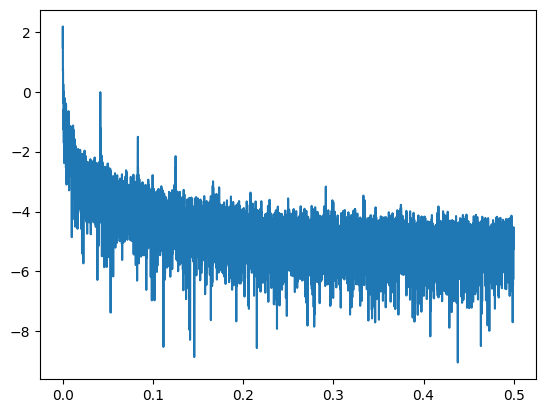

In [43]:
plt.plot(freqs, torch.log(amps))

In [44]:
topk = torch.topk(amps, k=k)


In [45]:
k = 20
phi = torch.sum(freqs[topk.indices] * amps[topk.indices]) / torch.sum(
    amps[topk.indices]
)
phi

tensor(0.0017)

In [46]:
tau = 1 / phi

In [47]:
n_tau = tau // T
n_tau = int(n_tau.item())
n_tau

600

In [48]:
m = 1
tP = tL + m * tau
tP

tensor(616.4062)

In [49]:
tK,tF,tP

(tensor(17419.), tensor(16.), tensor(616.4062))

In [50]:
delta_ta = tK - tF - tP
delta_ta

tensor(16786.5938)

In [51]:
N = delta_ta // tP
N = int(N.item())
N

27

In [52]:
use_cuda = True
device = torch.device("cuda:0" if use_cuda and torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [53]:
l = nn.Linear(in_features=(m + 1) * L, out_features=F)
l = l.to(device=device)
l

Linear(in_features=32, out_features=16, bias=True)

  0%|          | 0/800 [00:00<?, ?it/s]

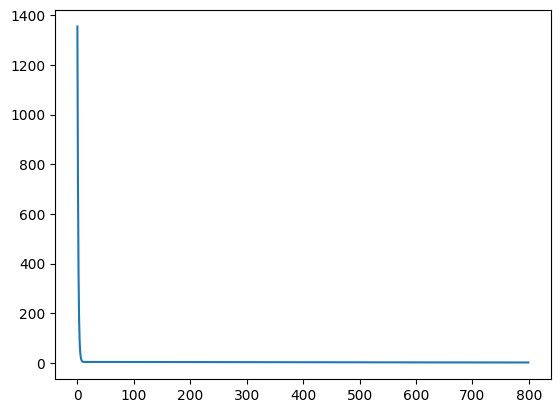

In [54]:
from tqdm.notebook import tqdm

n = 2
B = N // n

# plt.figure(figsize=(16, 4 * N))


optim = torch.optim.Adam(l.parameters(), lr=0.001)
criterion = nn.MSELoss()

total_loss = []

Y = None
Y_pred = None

for epoch in tqdm(range(800)):
    loss = None
    for i in range(B):
        X = []
        Y = []
        # 组装每批的数据
        for j in range(n):
            a = i * n + j
            b = a + L + m * n_tau
            c = b + F
            # plt.subplot(N, 1, a + 1)
            all_segments = []
            # segments
            for k in range(m + 1):
                starts = a + k * n_tau
                # plt.axvline(x=starts, color="blue")
                ends = a + L + k * n_tau
                # plt.axvline(x=ends, color="blue")
                all_segments.append(x[starts:ends])
            x_line = torch.cat(all_segments)
            X.append(x_line)
            # plt.title(f"{a=}")
            y_line = x[b:c]
            Y.append(y_line)
        # 每批的数据
        X = torch.stack(X).to(device=device)
        Y = torch.stack(Y).to(device=device)
        Y_pred = l(X)
        loss: torch.Tensor = criterion(Y_pred, Y)
        # print(f"{loss=}")
        optim.zero_grad()
        loss.backward()
        optim.step()

    total_loss.append(loss.item())

plt.plot(total_loss)

In [55]:
total_loss[-1]

1.6942769652904497